In [ ]:
# default_exp data.core

# Data Core

> Main Numpy and Times Series functions used throughout the library.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *
from tsai.data.external import *

In [ ]:
#export
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors

In [ ]:
dsid = 'OliveOil'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, on_disk=True, force_download=True)
X_on_disk, y_on_disk, splits = get_UCR_data(dsid, on_disk=True, return_split=False, force_download=True)
X_in_memory, y_in_memory, splits = get_UCR_data(dsid, on_disk=False, return_split=False, force_download=True)
y_tensor = cat2int(y_on_disk)
y_array = y_tensor.numpy()

In [ ]:
#export
class NumpyTensor(TensorBase):
    "Returns a `tensor` with subclass `NumpyTensor` that has a show method"

    def __new__(cls, o, **kwargs):
        if isinstance(o, (list, L)): o = stack(o)
        res = cast(tensor(o), cls)
        for k,v in kwargs.items(): setattr(res, k, v)
        return res
        
    @property
    def data(self): return cast(self, Tensor).data
    
    def __repr__(self):
        if self.ndim > 0: return f'NumpyTensor(shape:{tuple(self.shape)})'
        else: return f'{self}'
        

    def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
        if self.ndim == 0: return str(self)
        elif self.ndim != 2: self = type(self)(to2d(self))
        self = self.detach().cpu().numpy()
        ax = ifnone(ax, ctx)
        if ax is None: _, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax


class ToNumpyTensor(Transform):
    "Transforms an object into NumpyTensor"
    def encodes(self, o): return NumpyTensor(o)

In [ ]:
#export
class TSTensor(NumpyTensor):
    '''Returns a `tensor` with subclass `TSTensor` that has a show method'''
    
    @property
    def vars(self): 
        if self.ndim >=4: return self.shape[-3]
        else: return self.shape[-2]

    @property
    def len(self): return self.shape[-1]

    def __repr__(self):
        if self.ndim >= 3:
            return f'TSTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 2:
            return f'TSTensor(vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 1:
            return f'TSTensor(len:{self.shape[-1]})'
        else: return f'TSTensor({self})'


class ToTSTensor(Transform):
    "Transforms an object into TSTensor"
    def encodes(self, o): return TSTensor(o)

In [ ]:
t = TSTensor(torch.randn(2, 3, 4))
p = torch.tensor(3., requires_grad=True)
test = torch.add(t, p)
test_eq(test.requires_grad, True)
test_eq(type(t.data), torch.Tensor)
test_eq(type(t), TSTensor)

In [ ]:
l = L([0,1,2,3], [4,5,6,7], [8, 9, 10, 11])
TSTensor(l), TSTensor(l).data

(TSTensor(vars:3, len:4),
 tensor([[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]))

In [ ]:
t = TSTensor(X_train)
for i in range(4):
    print(t)
    if i < 3: t = t[0]

TSTensor(samples:30, vars:1, len:570)
TSTensor(vars:1, len:570)
TSTensor(len:570)
TSTensor(-0.6113752722740173)


In [ ]:
TSTensor(X_on_disk)

TSTensor(samples:60, vars:1, len:570)

In [ ]:
ToTSTensor()(X_on_disk)

TSTensor(samples:60, vars:1, len:570)

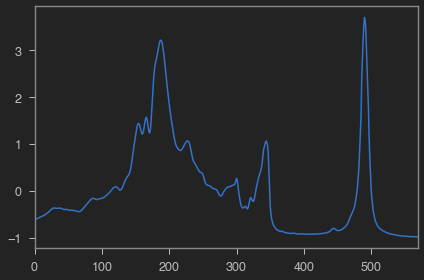

In [ ]:
TSTensor(X_train).show();

In [ ]:
# export
class TSLabelTensor(NumpyTensor): 
    def __repr__(self):
        if self.ndim == 0: return f'{self}'
        else: return f'TSLabelTensor(shape:{tuple(self.shape)})'

In [ ]:
t = TSLabelTensor(torch.randint(0,10,(1, 2, 3)))
t, t[0], t[0][0], t[0][0][0]

(TSLabelTensor(shape:(1, 2, 3)),
 TSLabelTensor(shape:(2, 3)),
 TSLabelTensor(shape:(3,)),
 9)

In [ ]:
#export
class ToFloat(Transform):
    "Transforms an object dtype to float"
    loss_func=MSELossFlat()
    def encodes(self, o:torch.Tensor): return o.float()
    def encodes(self, o): return o.astype(np.float32)
    def decodes(self, o): return TitledFloat(o) if o.ndim==0 else TitledTuple(o_.item() for o_ in o)


class ToInt(Transform):
    "Transforms an object dtype to int"
    def encodes(self, o:torch.Tensor): return o.long()
    def encodes(self, o): return o.astype(np.float32).astype(np.int64)
    def decodes(self, o): return TitledFloat(o) if o.ndim==0 else TitledTuple(o_.item() for o_ in o)
    
    
TSClassification = Categorize
TSMultiLabelClassification = MultiCategorize
TSRegression = ToFloat
TSForecasting = ToFloat

In [ ]:
a = np.random.randint(0, 2, 10)
b = np.array(['1', '2', '3'])
c = np.array(['1.0', '2.0', '3.0'])
t = torch.randint(0, 2, (10, ))
test_eq(ToFloat()(a).dtype, 'float32')
test_eq(ToFloat()(b).dtype, 'float32')
test_eq(ToFloat()(c).dtype, 'float32')
test_eq(ToFloat()(t).dtype, torch.float32)

In [ ]:
a = np.random.rand(10)*10
b = np.array(['1.0', '2.0', '3.0'])
t = torch.rand(10)*10
test_eq(ToInt()(a).dtype, 'int64')
test_eq(ToInt()(b).dtype, 'int64')
test_eq(ToInt()(t).dtype, torch.long)

In [ ]:
#export
class NumpyTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =                 L(type_tfms)
        self.item_tfms  = ToNumpyTensor + L(item_tfms)
        self.batch_tfms =                 L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
        
class TSTensorBlock():
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =              L(type_tfms)
        self.item_tfms  = ToTSTensor + L(item_tfms)
        self.batch_tfms =              L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [ ]:
test_eq(NumpyTensorBlock().item_tfms[0].__name__, 'ToNumpyTensor')
test_eq(TSTensorBlock().item_tfms[0].__name__, 'ToTSTensor')

In [ ]:
#export
class TorchDataset():
    def __init__(self, X, y=None): self.X, self.y = X, y
    def __getitem__(self, idx): return (self.X[idx],) if self.y is None else (self.X[idx], self.y[idx])
    def __len__(self): return len(self.X)

    
class NumpyDataset():
    def __init__(self, X, y=None, types=None): self.X, self.y, self.types = X, y, types
    def __getitem__(self, idx):
        if self.types is None: return (self.X[idx], self.y[idx]) if self.y is not None else (self.X[idx])
        else: return (self.types[0](self.X[idx]), self.types[1](self.y[idx])) if self.y is not None else (self.types[0](self.X[idx]))
    def __len__(self): return len(self.X)


class TSDataset():
    def __init__(self, X, y=None, types=None, sel_vars=None, sel_steps=None):
        self.X, self.y, self.types = to3darray(X), y, types
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
    def __getitem__(self, idx):
        if self.types is None: return (self.X[idx, self.sel_vars, self.sel_steps], self.y[idx]) if self.y is not None else (self.X[idx])
        else:
            return (self.types[0](self.X[idx, self.sel_vars, self.sel_steps]), self.types[1](self.y[idx])) if self.y is not None \
            else (self.types[0](self.X[idx]))
    def __len__(self): return len(self.X)

In [ ]:
a = np.random.rand(5,6,7)
b = np.random.rand(5)
ds = NumpyDataset(a,b)
xb, yb = ds[[0,4]]
test_eq(xb.shape, (2,6,7))
test_eq(yb.shape, (2,))

In [ ]:
#export
@delegates(Datasets.__init__)
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `tfms` of type item_tfms"
    _xtype, _ytype = NumpyTensor, None # Expected X and y output types (must have a show method)
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, inplace=True, **kwargs):
        if X is not None and not isinstance(X, (np.ndarray, torch.Tensor)): X = np.asarray(X)
        if y is not None and not isinstance(y, (np.ndarray, torch.Tensor)): y = np.asarray(y)
        self.inplace = inplace
        if tls is None: 
            X = itemify(X, tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if 'split' in kwargs: self.split_idxs = kwargs['split']
        elif 'splits' in kwargs:  self.split_idxs = kwargs['splits']
        else: self.split_idxs = L(np.arange(len(self.tls[0]) if len(self.tls[0]) > 0 else len(self.tls)).tolist())
        if len(self.tls[0]) > 0: 
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for tl,_typ in zip(self.tls, [self._xtype, self._ytype])])
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else tensor(stack(tl[:])) for tl in self.tls])
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, inplace=self.inplace, tfms=self.tfms,
                                          split=L(self.splits[i]) if self.splits is not None else None)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = tuple((X,)) if y is None else tuple((X, y))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    def show_at(self, idx, **kwargs):
        self.show(self[idx], **kwargs)
        plt.show()
        
    @property
    def items(self): return tuple([tl.items for tl in self.tls])
    
    @items.setter
    def items(self, vs):
        for tl,v in zip(self.tls, vs): tl.items = v


@delegates(NumpyDatasets.__init__)
class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 inplace=True, **kwargs):
        if X is not None and not isinstance(X, (np.ndarray, torch.Tensor)): X = np.asarray(X)
        if y is not None and not isinstance(y, (np.ndarray, torch.Tensor)): y = np.asarray(y)
        self.inplace = inplace
        if tls is None: 
            X = itemify(to3darray(X), tup_id=0)
            y = itemify(y, tup_id=0) if y is not None else y
            items = tuple((X,)) if y is None else tuple((X,y))
            self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        if 'split' in kwargs: self.split_idxs = kwargs['split']
        elif 'splits' in kwargs:  self.split_idxs = kwargs['splits']
        else: self.split_idxs = L(np.arange(len(self.tls[0]) if len(self.tls[0]) > 0 else len(self.tls)).tolist())
        if len(self.tls[0]) > 0: 
            self.types = L([ifnone(_typ, type(tl[0]) if isinstance(tl[0], torch.Tensor) else tensor) for tl,_typ in zip(self.tls, [self._xtype, self._ytype])])
            self.ptls = L([tl if not self.inplace else tl[:] if type(tl[0]).__name__ == 'memmap' else tensor(stack(tl[:])) for tl in self.tls])
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it])[...,self.sel_vars, self.sel_steps] if i==0 else typ(ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])

    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, inplace=self.inplace, tfms=self.tfms, 
                                           sel_vars=self.sel_vars, sel_steps=self.sel_steps, split=L(self.splits[i]) if self.splits is not None else None)
    
    
def add_ds(dsets, X, y=None, inplace=True):
    "Create test datasets from X (and y) using validation transforms of `dsets`"
    items = tuple((X,)) if y is None else tuple((X, y))
    with_labels = False if y is None else True
    if isinstance(dsets, (Datasets, NumpyDatasets, TSDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        if isinstance(dsets, TSDatasets):
            return TSDatasets(tls=new_tls, n_inp=dsets.n_inp, inplace=inplace, tfms=dsets.tfms,
                              sel_vars=dsets.sel_vars, sel_steps=dsets.sel_steps)
        elif isinstance(dsets, NumpyDatasets):
            return NumpyDatasets(tls=new_tls, n_inp=dsets.n_inp, inplace=inplace, tfms=dsets.tfms)
        elif isinstance(dsets, Datasets): return Datasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

@patch
def add_dataset(self:NumpyDatasets, X, y=None, inplace=True):
    return add_ds(self, X, y=y, inplace=inplace)

@patch
def add_test(self:NumpyDatasets, X, y=None, inplace=True):
    return add_ds(self, X, y=y, inplace=inplace)

@patch
def add_unlabeled(self:NumpyDatasets, X, inplace=True):
    return add_ds(self, X, y=None, inplace=inplace)

def get_subset_dset(dset, idxs):
    if isinstance(dset, TabularPandas):
        new_dset =  dset.iloc[idxs]
        new_dset.items.reset_index(drop=True, inplace=True)
        return new_dset
    items = tuple([L(item)[idxs] for item in dset.items])
    if isinstance(dset, (Datasets, NumpyDatasets, TSDatasets)):
        new_tls = L([tl._new(item, split_idx=dset.split_idx) for tl,item in zip(dset.tls, items)])
        if isinstance(dset, TSDatasets):
            return TSDatasets(tls=new_tls, n_inp=dset.n_inp, inplace=dset.inplace, tfms=dset.tfms, sel_vars=dset.sel_vars, sel_steps=dset.sel_steps)
        elif isinstance(dset, NumpyDatasets):
            return NumpyDatasets(tls=new_tls, n_inp=dset.n_inp, inplace=dset.inplace, tfms=dset.tfms)
        elif isinstance(dset, Datasets): return Datasets(tls=new_tls)
    elif isinstance(dset, TfmdLists):
        return dset._new(items, split_idx=dset.split_idx)
    else: raise Exception(f"Expected a `Datasets`, `TfmdLists` of `TabularPandas` dataset but got {dset.__class__.__name__}")

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=False)
dsets2 = TSDatasets(X_on_disk[:, 0], y_array, tfms=None, splits=splits, inplace=True)
test_eq_type(dsets[0][0].data, dsets2[0][0].data)
mini_dsets = get_subset_dset(dsets.train, np.arange(10))
test_eq(len(mini_dsets), 10)
test_eq(type(mini_dsets), type(dsets))

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=False)
torch.save(dsets, 'export/dsets.pth')
del dsets
dsets = torch.load('export/dsets.pth')
dsets

(#60) [(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1))...]

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=False)
torch.save(dsets.train, 'export/dsets.pth')
del dsets
dsets = torch.load('export/dsets.pth')
dsets

(#30) [(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(0)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1)),(TSTensor(vars:1, len:570), tensor(1))...]

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=False)
test_eq(len(dsets.train), len(X_train))
dsets = TSDatasets(X_on_disk, y_array, tfms=None, splits=splits, inplace=True)
test_eq(len(dsets.train), len(X_train))
dsets = TSDatasets(X_on_disk, y_array, tfms=[add(1), Categorize()], splits=splits, inplace=True)
test_eq(len(dsets.train), len(X_train))
# test_eq(dsets.train[0][0].data, tensor(X_train[0] + 1))
test_eq(dsets.train[0][1].data, y_tensor[0])

In [ ]:
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=[None, Categorize()], splits=splits, inplace=True)
test_eq(len(dsets.add_test(X_train, y_train)), len(X_train))
test_eq(len(dsets.add_unlabeled(X_train)), len(X_train))

In [ ]:
# export
@patch
def _one_pass(self:TfmdDL):
    b = self.do_batch([self.do_item(0)])
    if self.device is not None: b = to_device(b, self.device)
    its = self.after_batch(b)
    self._n_inp = 1 if not isinstance(its, (list,tuple)) or len(its)==1 else len(its)-1
    self._types = explode_types(its)

In [ ]:
# export
_batch_tfms = ('after_item','before_batch','after_batch')

@delegates(TfmdDL.__init__)
class NumpyDataLoader(TfmdDL):
    idxs = None
    do_item = noops # create batch returns indices
    def __init__(self, dataset, bs=64, shuffle=True, drop_last=True, num_workers=None, verbose=False, do_setup=True, batch_tfms=None, **kwargs):
        '''batch_tfms == after_batch (either can be used)'''
        if num_workers is None: num_workers = min(16, defaults.cpus)
        for nm in _batch_tfms:
            if nm == 'after_batch':
                if batch_tfms is not None: kwargs[nm] = Pipeline(batch_tfms if isinstance(batch_tfms, list) else [batch_tfms])
                else: kwargs[nm] = Pipeline(kwargs.get(nm,None))
            else: kwargs[nm] = Pipeline(kwargs.get(nm,None))
        bs = min(bs, len(dataset))
        super().__init__(dataset, bs=bs, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers, **kwargs)
        if do_setup:
            for nm in _batch_tfms:
                pv(f"Setting up {nm}: {kwargs[nm]}", verbose)
                kwargs[nm].setup(self)

    def create_batch(self, b):
        it = b if self.shuffle else slice(b[0], b[0] + self.bs)
        self.idxs = L(b)
        if hasattr(self, "split_idxs"): self.input_idxs = self.split_idxs[it]
        else: self.input_idxs = self.idxs
        return self.dataset[it]

    def create_item(self, s):
        if self.indexed: return self.dataset[s or 0]
        elif s is None:  return next(self.it)
        else: raise IndexError("Cannot index an iterable dataset numerically - must use `None`.")
#         return s

#     def get_idxs(self):
#         idxs = Inf.count if self.indexed else Inf.nones
#         if self.n is not None: idxs = list(itertools.islice(idxs, self.n))
#         if self.shuffle: idxs = self.shuffle_fn(idxs)
#         return idxs

#     def shuffle_fn(self, idxs): 
#         return self.rng.sample(idxs, len(idxs))

    def get_idxs(self):
        idxs = Inf.count if self.indexed else Inf.nones
        if self.n is not None: idxs = np.arange(self.n)
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs
    
    def shuffle_fn(self, idxs): 
        return np.random.permutation(idxs)
    
    def unique_batch(self, max_n=9):
        old_bs = self.bs
        self.bs = 1
        old_get_idxs = self.get_idxs
        self.get_idxs = lambda: Inf.zeros
        out_len = len(self.items)
        types = self.dataset.types
        x, y = [], []
        for _ in range(max_n):
            out = self.one_batch()
            if out_len == 2:
                x.extend(out[0])
                y.extend(out[1])
            else:
                x.extend(out)
        b = (types[0](stack(x)), types[1](stack(y))) if out_len == 2 else (types[0](stack(x)), )
        self.bs = old_bs
        self.get_idxs = old_get_idxs
        return b


    @delegates(plt.subplots)
    def show_batch(self, b=None, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=None, unique=False, sharex=True, sharey=False, **kwargs):
        if unique:
            b = self.unique_batch(max_n=max_n)
            sharex, sharey = True, True
        elif b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        ncols = min(ncols, math.ceil(len(db) / ncols))
        nrows = min(nrows, math.ceil(len(db) / ncols))
        max_n = min(max_n, len(db), nrows*ncols)
        if figsize is None: figsize = (ncols*6, math.ceil(max_n/ncols)*4)
        if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey, **kwargs)
        for i,ctx in enumerate(ctxs): show_tuple(db[i], ctx=ctx)

    @delegates(plt.subplots)
    def show_results(self, b, preds, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=None, **kwargs):
        t = self.decode_batch(b, max_n=max_n)
        p = self.decode_batch((b[0],preds), max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(t), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs):
            title = f'True: {t[i][1]}\nPred: {p[i][1]}'
            color = 'green' if t[i][1] == p[i][1] else 'red'
            t[i][0].show(ctx=ctx, title=title, title_color=color)

    @delegates(plt.subplots)
    def show_dist(self, figsize=None, color=None, **kwargs):
        if self.c == 0: 
            print('\nunlabeled dataset.\n')
            return
        b = self.one_batch()
        i = getattr(self, 'n_inp', 1 if len(b)==1 else len(b)-1)
        yb = b[i:][0].flatten().detach().cpu().numpy()
        if color == "random": color = random_shuffle(L(mcolors.CSS4_COLORS.keys()))
        elif color is None: color = ['m', 'orange', 'darkblue', 'lightgray']
        figsize = ifnone(figsize, (8, 6))
        plt.figure(figsize=figsize, **kwargs)
        ax = plt.axes()
        ax.set_axisbelow(True)
        plt.grid(color='gainsboro', linewidth=.1)
        plt.title('Target distribution in a single batch', fontweight='bold')
        if self.cat: 
            data = np.unique(yb, return_counts=True)[1]
            data = data / np.sum(data)
            plt.bar(self.vocab, data, color=color, edgecolor='black')
            plt.xticks(self.vocab)
        else: 
            weights=np.ones(len(yb)) / len(yb)
            plt.hist(yb, bins=min(len(yb) // 2, 100), weights=weights, color='violet', edgecolor='black')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.show()

    @property
    def c(self): 
        if hasattr(self, "vocab"): 
            return len(self.vocab)
        else:
            return self.d if not is_listy(self.d) else reduce(lambda x, y: x * y, self.d, 1)
    
    @property
    def d(self): 
        b = self.one_batch()
        if len(b) == 1: return 0
        i = getattr(self, 'n_inp', 1 if len(b)==1 else len(b)-1)
        yb = b[i:]
        if len(yb[0][0].shape) == 0: return 1
        elif len(yb[0][0].shape) == 1: return yb[0][0].shape[0]
        else: return list(yb[0][0].shape)

    @property
    def cat(self): return hasattr(self, "vocab")
    
#     @property
#     def loss_func(self): 
#         return MSELossFlat() if not self.cat else CrossEntropyLossFlat()

    @property
    def cws(self):
        if self.cat:
            counts = torch.unique(self.ptls[1].detach().cpu().flatten(), return_counts=True, sorted=True)[-1]
            iw = (counts.sum() / counts)
            return (iw / iw.sum()).to(self.device)
        else: return None
        
    @property
    def class_priors(self):
        if self.cws is not None:
            cp = 1. / (self.cws + 1e-8)
            return (cp / cp.sum()).to(self.device)
        else: return None


@delegates(plt.subplots)
def show_tuple(tup, **kwargs):
    "Display a timeseries plot from a decoded tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else str(tup[1]), **kwargs)

class TSDataLoader(NumpyDataLoader):
    @property
    def vars(self):
        b = self.one_batch()
        i = getattr(self, 'n_inp', 1 if len(b)==1 else len(b)-1)
        xb = b[:i]
        return xb[0][0].vars
    @property
    def len(self): 
        b = self.one_batch()
        i = getattr(self, 'n_inp', 1 if len(b)==1 else len(b)-1)
        xb = b[:i]
        return xb[0][0].len

In [ ]:
# export
_batch_tfms = ('after_item','before_batch','after_batch')

class NumpyDataLoaders(DataLoaders):
    _xblock = NumpyTensorBlock
    _dl_type = NumpyDataLoader
    def __init__(self, *loaders, path='.', device=None):
        self.loaders, self.path = list(loaders), Path(path)
        self.device = ifnone(device, default_device())

    def new_dl(self, x, y=None):
        if x.ndim == 1: x = [to2d(x)]
        elif x.ndim ==2 and not is_listy(x): x = [x]
        if y is not None and not is_listy(y) and not isinstance(y, (np.ndarray, torch.Tensor)): y = [y]
        return self.valid.new(self.valid.dataset.add_dataset(x, y=y))

    @delegates(plt.subplots)
    def show_dist(self, figsize=None, **kwargs): self.loaders[0].show_dist(figsize=figsize, **kwargs)

    def decoder(self, o):
        if isinstance(o, tuple): return self.decode(o)
        if o.ndim <= 1: return self.decodes(o)
        else: return L([self.decodes(oi) for oi in o])
        
    def decode(self, b): 
        return to_cpu(self.after_batch.decode(self._retain_dl(b)))


    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(cls._xblock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

    @classmethod
    def from_dsets(cls, *ds, path='.', bs=64, num_workers=0, batch_tfms=None, device=None, shuffle_train=True, drop_last=True, **kwargs):
        device = ifnone(device, default_device())
        if batch_tfms is not None and not isinstance(batch_tfms, list): batch_tfms = [batch_tfms]
        default = (shuffle_train,) + (False,) * (len(ds)-1)
        defaults = {'shuffle': default, 'drop_last': default}
        kwargs = merge(defaults, {k: tuplify(v, match=ds) for k,v in kwargs.items()})
        kwargs = [{k: v[i] for k,v in kwargs.items()} for i in range_of(ds)]
        if not is_listy(bs): bs = [bs]
        if len(bs) != len(ds): bs = bs * len(ds)
        loaders = [cls._dl_type(d, bs=b, num_workers=num_workers, batch_tfms=batch_tfms, **k) for d,k,b in zip(ds, kwargs, bs)]
        return cls(*loaders, path=path, device=device)


class TSDataLoaders(NumpyDataLoaders):
    _xblock = TSTensorBlock
    _dl_type = TSDataLoader


def get_ts_dls(X, y=None, splits=None, sel_vars=None, sel_steps=None, tfms=None, inplace=True,
            path='.', bs=64, batch_tfms=None, num_workers=0, device=None, shuffle_train=True, drop_last=True, **kwargs):
    if splits is None: splits = (L(np.arange(len(X)).tolist()), L([]))
    dsets = TSDatasets(X, y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, **kwargs)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers,
                                     device=device, shuffle_train=shuffle_train, drop_last=drop_last, **kwargs)
    return dls

def get_ts_dls(X, y=None, splits=None, sel_vars=None, sel_steps=None, tfms=None, inplace=True,
            path='.', bs=64, batch_tfms=None, num_workers=0, device=None, shuffle_train=True, drop_last=True, **kwargs):
    if splits is None: splits = (L(np.arange(len(X)).tolist()), L([]))
    dsets = TSDatasets(X, y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers,
                                     device=device, shuffle_train=shuffle_train, drop_last=drop_last, **kwargs)
    return dls

def get_ts_dl(X, y=None, sel_vars=None, sel_steps=None, tfms=None, inplace=True,
            path='.', bs=64, batch_tfms=None, num_workers=0, device=None, shuffle_train=True, drop_last=True, **kwargs):
    splits = (L(np.arange(len(X)).tolist()), L([]))
    dsets = TSDatasets(X, y, splits=splits, sel_vars=sel_vars, sel_steps=sel_steps, tfms=tfms, inplace=inplace, **kwargs)
    dls   = TSDataLoaders.from_dsets(dsets.train, path=path, bs=bs, batch_tfms=batch_tfms, num_workers=num_workers,
                                     device=device, shuffle_train=shuffle_train, drop_last=drop_last, **kwargs)
    return dls.train

get_tsimage_dls = get_ts_dls

def get_subset_dl(dl, idx):
    subset_dset = get_subset_dset(dl.dataset, idx)
    return dl.new(subset_dset)

In [ ]:
X, y, splits = get_UCR_data(dsid, on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, Categorize()], splits=splits, bs=8)
b=first(dls.train)
dls.decode(b)
test_eq(X.shape[1], dls.vars)
test_eq(X.shape[-1], dls.len)

In [ ]:
X, y, splits = get_UCR_data(dsid, on_disk=False, split_data=False)
dsets = TSDatasets(X, y, tfms=[None, Categorize()], splits=splits)
ts_dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, device=default_device(), bs=4)
torch.save(ts_dls, 'export/ts_dls.pth')
del ts_dls
ts_dls = torch.load('export/ts_dls.pth')
for xb,yb in ts_dls.train: 
    test_eq(tensor(X[ts_dls.train.idxs]), xb)

In [ ]:
X, y, splits = get_UCR_data(dsid, on_disk=False, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, Categorize()], splits=splits, bs=4)
for xb,yb in dls.train:
    test_eq(xb.cpu().numpy(), X[dls.train.input_idxs])
for xb,yb in dls.valid:
    test_eq(xb.cpu().numpy(), X[dls.valid.input_idxs])

In [ ]:
test_eq((ts_dls.train.shuffle, ts_dls.valid.shuffle, ts_dls.train.drop_last, ts_dls.valid.drop_last), (True, False, True, False))

In [ ]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, Categorize()], splits=splits, bs=8, num_workers=0)
xb, yb = first(dls.train)
test_eq(tensor(X[dls.train.idxs]), xb)

In [ ]:
test_eq((dls.train.shuffle, dls.valid.shuffle, dls.train.drop_last, dls.valid.drop_last), (True, False, True, False))

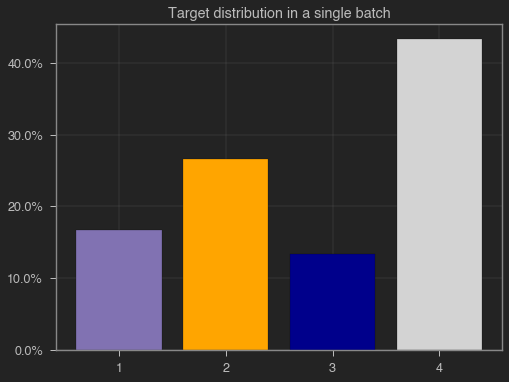

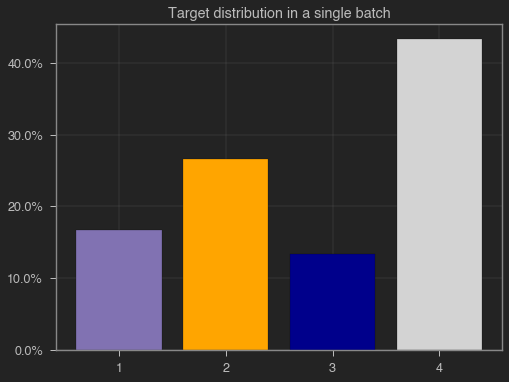

TensorCategory([0.3068, 0.1917, 0.3835, 0.1180])

In [ ]:
# multiclass
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
dls = get_ts_dls(X, y, tfms=[None, Categorize()], splits=splits)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
test_eq((dls.cat, dls.c), (True, 4))
test_ne(dls.cws.numpy(), None)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])
dls.cws

In [ ]:
new_dl = dls.new_dl(X)
first(new_dl)

(TSTensor(samples:30, vars:1, len:570),)

In [ ]:
new_dl = dls.new_dl(X, y=y)
first(new_dl)

(TSTensor(samples:30, vars:1, len:570),
 TensorCategory([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3]))

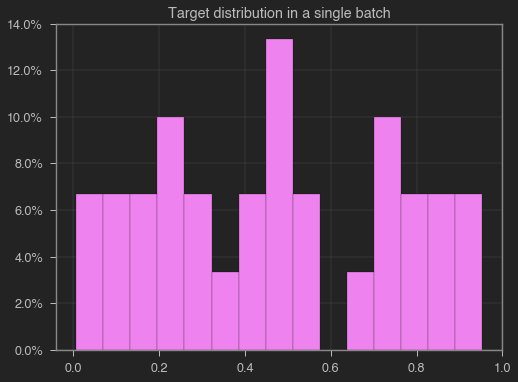

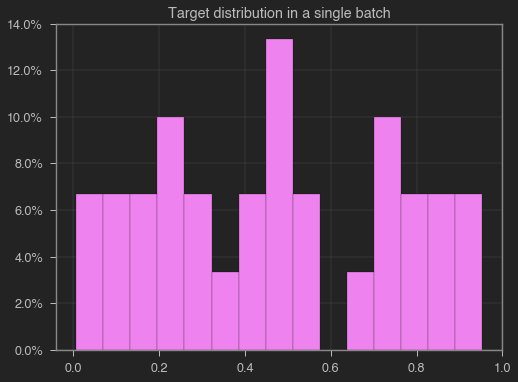

In [ ]:
# regression
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
dls = get_ts_dls(X, np.random.rand(60, ), tfms=[None, ToNumpyTensor], splits=splits)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])
test_eq((dls.cat, dls.c), (False, 1))
test_eq(dls.cws, None)

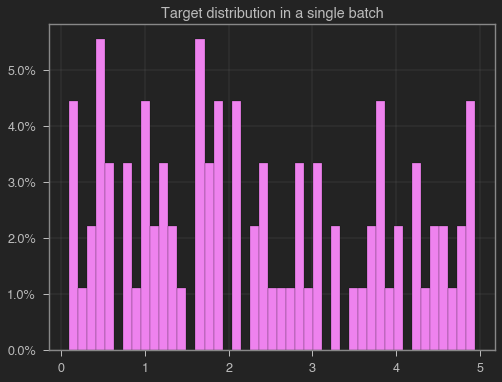

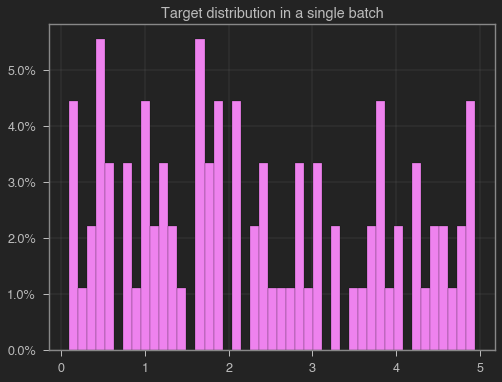

In [ ]:
# regression, multilabel
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
dls = get_ts_dls(X, np.random.rand(60, 3) * 5, tfms=[None, ToNumpyTensor], splits=splits)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])
test_eq((dls.cat, dls.c, dls.d),(False, 3, 3)) 
test_eq(dls.cws, None)

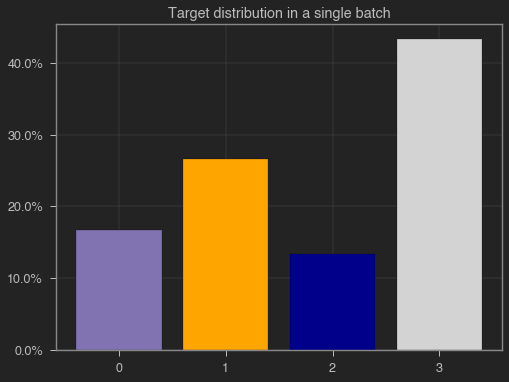

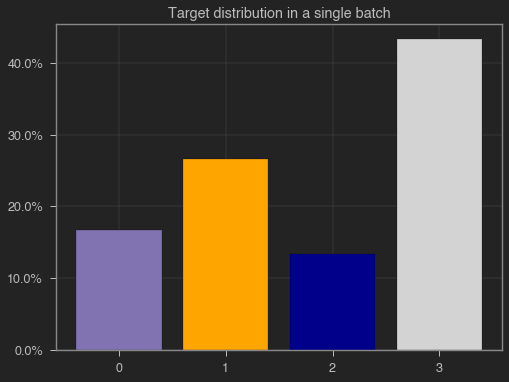

In [ ]:
# multiclass, multilabel
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, on_disk=True, split_data=False)
dls = get_ts_dls(X, np.repeat(y_array.reshape(-1,1), 3, 1), tfms=[None, MultiCategorize()], splits=splits)
dls.show_dist()
dls.train.show_dist()
xb,yb = first(dls.train)
dls.decoder((xb, ))
dls.decoder((xb[0], ))
dls.decoder((xb, yb))
dls.decoder((xb[0], yb[0]))
dls.decoder(yb)
dls.decoder(yb[0])
test_eq((dls.cat, dls.c), (True, 4))
test_ne(dls.cws.numpy(), None)

In [ ]:
bs = 25
dsets = TSDatasets(X, y, tfms=[None, Categorize()], splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2], batch_tfms=add(1), num_workers=0)
xb,yb = dls.train.one_batch()
test_eq(xb.data, tensor(X_on_disk[splits[0]][dls.train.idxs]) + 1)

In [ ]:
dsets = TSDatasets(X, y, tfms=[None, Categorize()], splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
xb,yb = dls.train.one_batch()
test_eq(xb.shape, (min(bs, len(splits[0])), X.shape[1], X.shape[-1]))
it = iter(dls.valid)
for xb,yb in it: 
    test_close(xb, TSTensor(X[splits[1]][dls.valid.idxs]))

In [ ]:
bs = 64
dsets = TSDatasets(X, y, tfms=[add(1), Categorize()], splits=RandomSplitter(valid_pct=.3)(y_array), inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])
xb,yb = dls.train.one_batch()
test_eq(xb.shape, (min(bs, len(dsets.train)), X_on_disk.shape[1], X_on_disk.shape[-1]))
xb,yb = dls.valid.one_batch()
test_eq(xb.shape, (min(bs*2, len(dsets.valid)), X_on_disk.shape[1], X_on_disk.shape[-1]))

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[32, 64])
for i in range(100):
    dl = dls.train if random.random() < .5 else dls.valid
    xb,yb = dl.one_batch()
    torch.equal(xb, TSTensor(X_on_disk[dl.input_idxs]))
    
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], inplace=True)
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
for i in range(100):
    xb,yb = dls.one_batch()
    torch.equal(xb, TSTensor(X_on_disk[dl.input_idxs]))
    
dsets = TSDatasets(X_on_disk, tfms=None, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
for i in range(100):
    xb = dls.one_batch()
    torch.equal(xb[0], TSTensor(X_on_disk[dl.input_idxs]))

In [ ]:
dsets = TSDatasets(X_on_disk, y_array, tfms=[None, Categorize()], inplace=True)
dls   = TSDataLoaders.from_dsets(dsets, bs=32)
test_eq_type(dls.split_idxs, L(np.arange(len(X_on_disk)).tolist()))

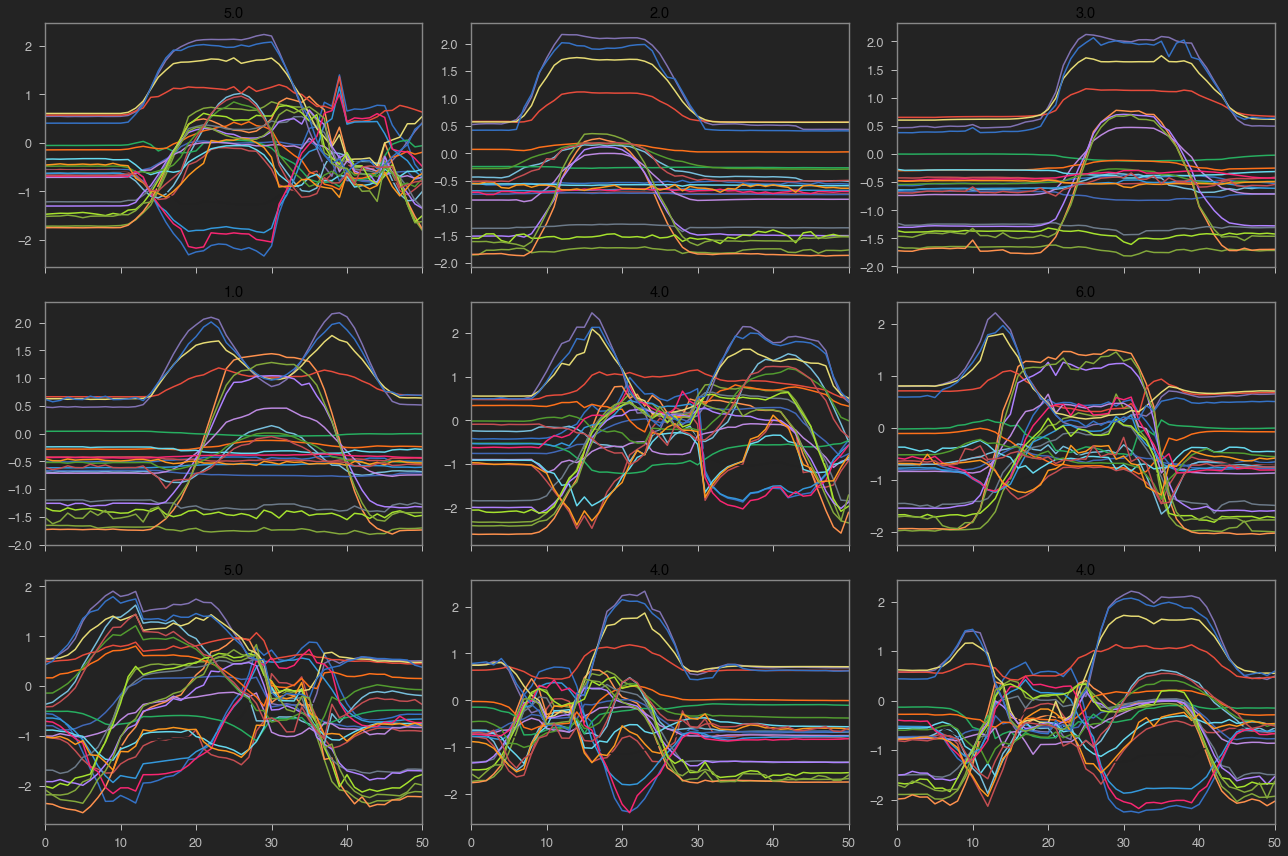

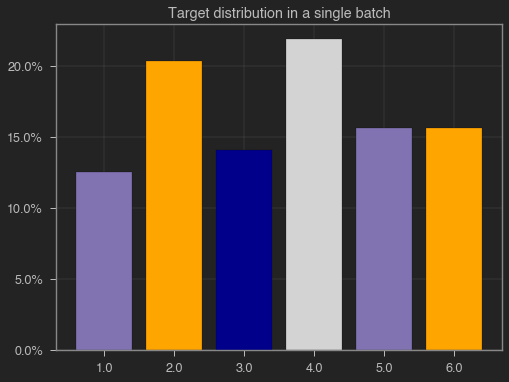

In [ ]:
X, y, splits = get_UCR_data('NATOPS', return_split=False)
tfms  = [None, [Categorize()]]
dls = get_ts_dls(X, y, tfms=tfms, splits=splits, bs=[64, 128])
dls.show_batch()
dls.show_dist()

In [ ]:
# test passing a list with categories instead of a numpy array 
dsid = 'NATOPS'
bs = 64
X, y, splits = get_UCR_data(dsid, return_split=False)
y = [str(z) for z in y]
vocab = sorted(set(y))
tfms = [None, [Categorize(vocab=vocab)]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [ ]:
#test of a MultiCategory
bs = 64
n_epochs = 100
tfms = [None, [MultiCategorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)
first(dls.train)

(TSTensor(samples:64, vars:24, len:51),
 TensorMultiCategory([[7, 0, 1],
         [6, 0, 1],
         [3, 0, 1],
         [7, 0, 1],
         [5, 0, 1],
         [6, 0, 1],
         [5, 0, 1],
         [2, 0, 1],
         [6, 0, 1],
         [6, 0, 1],
         [7, 0, 1],
         [3, 0, 1],
         [7, 0, 1],
         [4, 0, 1],
         [3, 0, 1],
         [2, 0, 1],
         [7, 0, 1],
         [2, 0, 1],
         [2, 0, 1],
         [7, 0, 1],
         [6, 0, 1],
         [4, 0, 1],
         [6, 0, 1],
         [6, 0, 1],
         [2, 0, 1],
         [4, 0, 1],
         [5, 0, 1],
         [2, 0, 1],
         [4, 0, 1],
         [7, 0, 1],
         [3, 0, 1],
         [2, 0, 1],
         [4, 0, 1],
         [3, 0, 1],
         [7, 0, 1],
         [6, 0, 1],
         [6, 0, 1],
         [4, 0, 1],
         [4, 0, 1],
         [6, 0, 1],
         [4, 0, 1],
         [5, 0, 1],
         [7, 0, 1],
         [5, 0, 1],
         [7, 0, 1],
         [5, 0, 1],
         [4, 0, 1],
       

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core-Copy1.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 008b_tslearner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.MVP.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.Ince